In [1]:
import importlib  
import pandas as pd
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import cv2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,mean_absolute_error,classification_report
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Conv1D, Dropout
import gc
from ipynb.fs.full.SIFT_to_Features import get_descriptors,get_vocab,descriptor_to_vocab,normalize_histograms
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#Simplifies adding a layer
def Convolution(input_tensor,filters):

    x = layers.Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same', activation = 'relu')(input_tensor)

    return x

def Convolution1D(input_tensor,filters):

    x = layers.Conv1D(filters=filters,kernel_size=(3),padding = 'same', activation = 'relu')(input_tensor)

    return x

#Simple CNN model
#Conv stands for neural network layers of (x,y). x standing for the input layers and y standing for how many filter layers there are
#maxp is a pooling layer that reduces the number of nodes of the next layer
#flatten changes the previous layer to a 1 dimensional layer
#dense layers have each node connected to every node in the previous layer. In this case, we have 3 dense layers of differing weights representing
#age, gender, and race. While all previous layers have collected features, dense layers calculate based on these collected features.
#They then send their calculations to the final dense layer to determine classification
#Binary Crossentropy = Classifies based on a binary value
#Sparse Categorical Crossentropy = Classifies based on an integer value with more than 2 possible values
def Simplemodel(input_shape,column):
  losstype = ""
  outputn = 0
  if(column == 'age'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 9
  if(column == 'gender'):
    losstype = "binary_crossentropy"
    outputn = 1
  if(column == 'race'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 5
    


  inputs = Input((input_shape))
  conv_1= Convolution(inputs,32)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,64)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,64)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  conv_5 = Convolution(maxp_4,64)
  flatten= Flatten() (conv_5)
  dense_1= Dense(64,activation='relu')(flatten)
  output_1= Dense(outputn,activation="sigmoid",name='out')(dense_1)
  model = Model(inputs=[inputs], outputs=[output_1])
  model.compile(loss=[losstype], optimizer="Adam",
  metrics=["accuracy"])

  return model

def Simplemodel1D(input_shape,column):
  losstype = ""
  outputn = 0
  if(column == 'age'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 9
  if(column == 'gender'):
    losstype = "binary_crossentropy"
    outputn = 1
  if(column == 'race'):
    losstype = "sparse_categorical_crossentropy"
    outputn = 5

  inputs = Input((input_shape))
  conv_1= Convolution1D(inputs,32)
  maxp_1 = MaxPooling1D(pool_size = 2) (conv_1)
  conv_2 = Convolution1D(maxp_1,64)
  maxp_2 = MaxPooling1D(pool_size = 2) (conv_2)
  conv_3 = Convolution1D(maxp_2,64)
  maxp_3 = MaxPooling1D(pool_size = 2) (conv_3)
  conv_4 = Convolution1D(maxp_3,64)
  maxp_4 = MaxPooling1D(pool_size = 2) (conv_4)
  conv_5 = Convolution1D(maxp_4,64)
  flatten= Flatten() (conv_5)
  dense_1= Dense(64,activation='relu')(flatten)
  output_1= Dense(outputn,activation="sigmoid",name='out')(dense_1)
  model = Model(inputs=[inputs], outputs=[output_1])
  model.compile(loss=[losstype], optimizer="Adam",
  metrics=["accuracy"])

  return model

### Set Labels and sample size

In [3]:
Labeltype = 'age'
samplesize = 5000

### Train test split imported data and balance train

In [4]:
# Import image labels and paths to dataframe
mypath = "../data/raw/CroppedImages/"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns).astype({'age': 'int', 'gender': 'int', 'race': 'int'})

# Convert age to appropriate labels
filedf['age']=np.where((filedf.age<3), 0, filedf.age)
filedf['age']=np.where(((filedf.age>=3) & (filedf.age<6)), 1, filedf.age)
filedf['age']=np.where(((filedf.age>=6) & (filedf.age<9)), 2, filedf.age)
filedf['age']=np.where(((filedf.age>=9) & (filedf.age<12)), 3, filedf.age)
filedf['age']=np.where(((filedf.age>=12) & (filedf.age<21)), 4, filedf.age)
filedf['age']=np.where(((filedf.age>=21) & (filedf.age<36)), 5, filedf.age)
filedf['age']=np.where(((filedf.age>=36) & (filedf.age<51)), 6, filedf.age)
filedf['age']=np.where(((filedf.age>=51) & (filedf.age<80)), 7, filedf.age)
filedf['age']=np.where((filedf.age>=80), 8, filedf.age)

dfx = filedf.loc[:,'file']
dfy = filedf.loc[:,Labeltype]

# Get Train/Test
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)

# Get Train/Test/Validation dataset 0.25 * 8 = 0.2
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Encode training labels and initialize random over sampler
yencoded = LabelEncoder().fit_transform(y_train_2)
oversample = RandomOverSampler()

# Over sample until training classes are balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(np.array(X_train_2).reshape(-1,1), yencoded)

# Of all classes, proportionally sample 
dxy = {'file': X_train_balanced.reshape(len(X_train_balanced)), 'label': y_train_balanced}
dfbalanced = pd.DataFrame(data = dxy)
balancedsamples = int(samplesize/len(set(dfbalanced.loc[:,'label'])))
dfbalancedsubset = dfbalanced.groupby('label', group_keys=False).apply(lambda x: x.sample(balancedsamples)).sample(frac=1)

### Count unbalanced, balanced, & balanced + sampled classes

In [5]:
# Count and print unbalanced classes
counter = Counter(y_train_2)
for k,v in counter.items():
    per = v / len(y_train_2) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes
counter = Counter(y_train_balanced)
for k,v in counter.items():
    per = v / len(y_train_balanced) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes subsets
counter = Counter(dfbalancedsubset.loc[:,'label'])
for k,v in counter.items():
    per = v / len(dfbalancedsubset.loc[:,'label']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=5, n=6093 (42.839%)
Class=2, n=331 (2.327%)
Class=6, n=2393 (16.825%)
Class=0, n=969 (6.813%)
Class=8, n=396 (2.784%)
Class=7, n=2405 (16.909%)
Class=3, n=231 (1.624%)
Class=4, n=954 (6.707%)
Class=1, n=451 (3.171%)
Class=5, n=6093 (11.111%)
Class=2, n=6093 (11.111%)
Class=6, n=6093 (11.111%)
Class=0, n=6093 (11.111%)
Class=8, n=6093 (11.111%)
Class=7, n=6093 (11.111%)
Class=3, n=6093 (11.111%)
Class=4, n=6093 (11.111%)
Class=1, n=6093 (11.111%)
Class=1, n=555 (11.111%)
Class=4, n=555 (11.111%)
Class=5, n=555 (11.111%)
Class=0, n=555 (11.111%)
Class=2, n=555 (11.111%)
Class=6, n=555 (11.111%)
Class=3, n=555 (11.111%)
Class=8, n=555 (11.111%)
Class=7, n=555 (11.111%)


### Function to get image data from urls

In [6]:
def get_images(filelist,rgb = True,normalize = False):
    dims = 0
    if(rgb):
        dims=3
    else:
        dims=1
    container = np.zeros((len(filelist),200,200,dims))
    if(normalize):
        for index,i in enumerate(filelist):
            img = cv2.imread(i)
            mini = np.min(img)
            maxi = np.max(img)
            img = (img - mini) / (maxi - mini) * 255
            if(not rgb):
                img = color.rgb2gray(img)
            container[index,:,:,:dims]=img
    else:
        for index,i in enumerate(filelist):
            img = cv2.imread(i)
            if(not rgb):
                img = color.rgb2gray(img)
            container[index,:,:,:dims]=img
    return container

### Image data of unbalanced train,test, and validation

In [7]:
train_img_container = get_images(X_train_2,rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)

### Clear data if necessary

In [79]:
del train_img_container
del validation_img_container
del test_img_container
del Modelsimple

NameError: name 'train_img_container' is not defined

### Get y values

In [10]:
y_unbalanced_train = y_train_2
y_train_label = dfbalancedsubset.loc[:,'label']
y_test = y_test
y_val = y_val

In [12]:
counter = Counter(y_val)
for k,v in counter.items():
    per = v / len(y_val) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=6, n=806 (17.001%)
Class=5, n=2073 (43.725%)
Class=7, n=729 (15.377%)
Class=0, n=308 (6.497%)
Class=8, n=145 (3.058%)
Class=4, n=336 (7.087%)
Class=1, n=157 (3.312%)
Class=3, n=92 (1.941%)
Class=2, n=95 (2.004%)


### Initialize callback

In [13]:
callback = tf.keras.callbacks.EarlyStopping(
monitor="val_accuracy",
verbose=1,
patience = 10,
mode="auto",
restore_best_weights=True,
)

### Create and run unbalanced model

In [14]:
Modelsimple=Simplemodel(train_img_container[0].shape,'age')

In [15]:
History = Modelsimple.fit(train_img_container[:5000]
                          ,y_train_2[:5000]
                          ,validation_data=(validation_img_container,y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 152s 966ms/step - loss: 2.2749 - accuracy: 0.4372 - val_loss: 1.5450 - val_accuracy: 0.4600
Epoch 2/10
157/157 [==============================] - 133s 848ms/step - loss: 1.3327 - accuracy: 0.5414 - val_loss: 1.3466 - val_accuracy: 0.5248
Epoch 3/10
157/157 [==============================] - 131s 833ms/step - loss: 1.1735 - accuracy: 0.5780 - val_loss: 1.2371 - val_accuracy: 0.5469
Epoch 4/10
157/157 [==============================] - 124s 791ms/step - loss: 1.0335 - accuracy: 0.6092 - val_loss: 1.2132 - val_accuracy: 0.5598
Epoch 5/10
157/157 [==============================] - 126s 806ms/step - loss: 0.9493 - accuracy: 0.6390 - val_loss: 1.1888 - val_accuracy: 0.5423
Epoch 6/10
157/157 [==============================] - 127s 811ms/step - loss: 0.8323 - accuracy: 0.6834 - val_loss: 1.2148 - val_accuracy: 0.5784
Epoch 7/10
157/157 [==============================] - 128s 815ms/step - loss: 0.7762 - accuracy: 0.6990 - val_loss: 1.2755 -

### Get predictions

In [16]:
ypredtrain = Modelsimple.predict(train_img_container[:5000])
ypredtest = Modelsimple.predict(test_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 22s 145ms/step


### Train classification report

In [17]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_2[:5000]))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       354
           1       0.73      0.94      0.82       131
           2       0.70      0.95      0.80        84
           3       0.80      0.94      0.87        72
           4       0.75      0.73      0.74       334
           5       0.90      0.90      0.90      2166
           6       0.77      0.78      0.78       820
           7       0.90      0.86      0.88       887
           8       0.93      0.86      0.89       152

    accuracy                           0.87      5000
   macro avg       0.83      0.88      0.85      5000
weighted avg       0.87      0.87      0.87      5000



### Validation classification report

In [18]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.74      0.79      0.77       308
           1       0.37      0.23      0.28       157
           2       0.21      0.06      0.10        95
           3       0.21      0.10      0.13        92
           4       0.25      0.22      0.23       336
           5       0.68      0.74      0.71      2073
           6       0.35      0.34      0.34       806
           7       0.51      0.56      0.54       729
           8       0.47      0.38      0.42       145

    accuracy                           0.56      4741
   macro avg       0.42      0.38      0.39      4741
weighted avg       0.54      0.56      0.54      4741



### Test classification report

In [19]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       328
           1       0.39      0.21      0.27       150
           2       0.29      0.07      0.12       107
           3       0.16      0.14      0.15        64
           4       0.22      0.22      0.22       304
           5       0.69      0.73      0.71      2064
           6       0.36      0.32      0.34       793
           7       0.53      0.57      0.55       799
           8       0.42      0.39      0.40       132

    accuracy                           0.56      4741
   macro avg       0.43      0.39      0.40      4741
weighted avg       0.55      0.56      0.55      4741



### Change label and title based on label type chosen

In [20]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Confusion matrix for validation

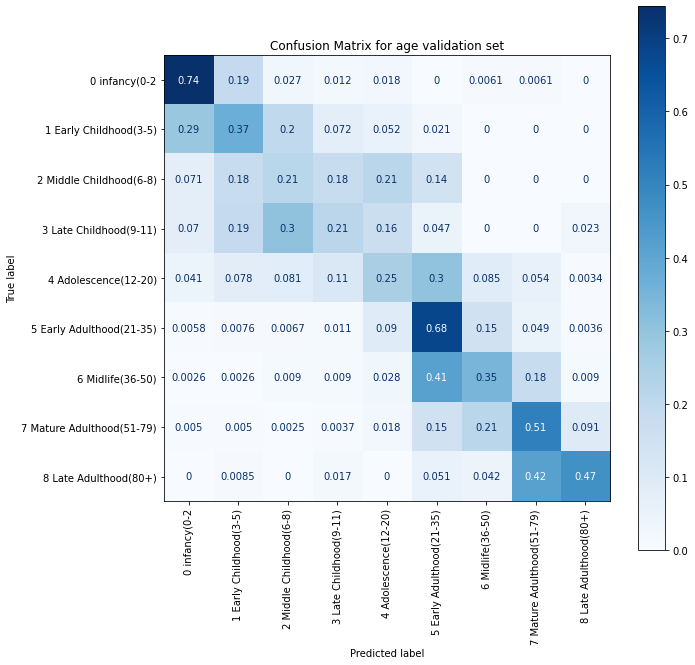

In [21]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Confusion matrix for test

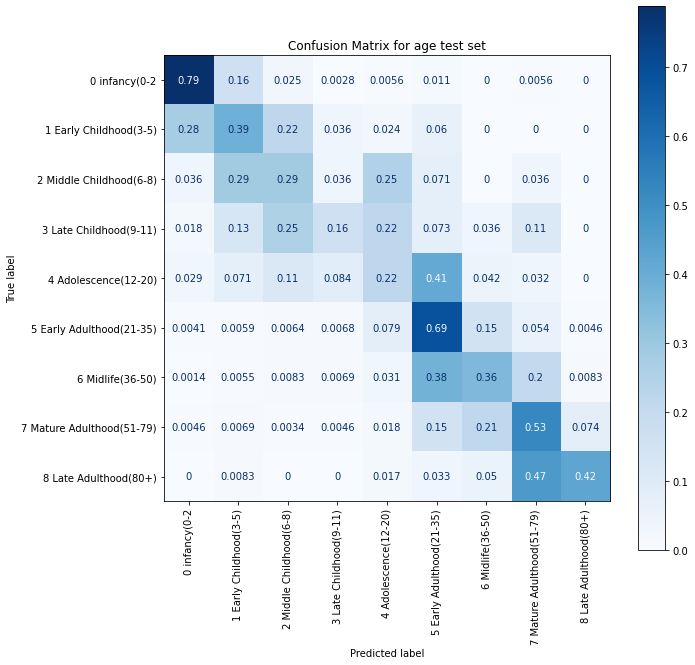

In [25]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Model accuracy

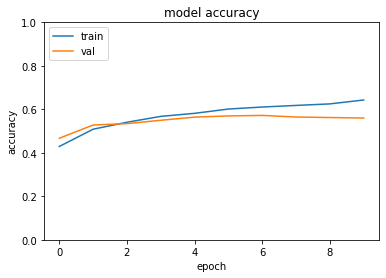

In [20]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model loss

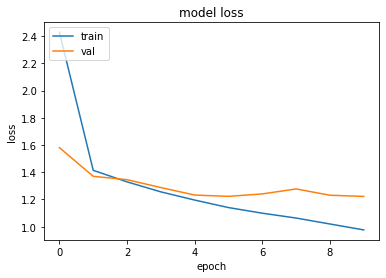

In [21]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Create and run balanced dataset

In [48]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)

### Create balanced model

In [65]:
Modelsimple=Simplemodel(train_img_container[0].shape,'age')

In [66]:
History = Modelsimple.fit(train_img_container
                          ,y_train_label
                          ,validation_data=(validation_img_container,y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 142s 900ms/step - loss: 2.6106 - accuracy: 0.1734 - val_loss: 2.0185 - val_accuracy: 0.2877
Epoch 2/10
157/157 [==============================] - 131s 835ms/step - loss: 1.9443 - accuracy: 0.2565 - val_loss: 2.0194 - val_accuracy: 0.2464
Epoch 3/10
157/157 [==============================] - 131s 837ms/step - loss: 1.6704 - accuracy: 0.3528 - val_loss: 1.4521 - val_accuracy: 0.4758
Epoch 4/10
157/157 [==============================] - 131s 837ms/step - loss: 1.4283 - accuracy: 0.4533 - val_loss: 1.4982 - val_accuracy: 0.4377
Epoch 5/10
157/157 [==============================] - 134s 852ms/step - loss: 1.2526 - accuracy: 0.5283 - val_loss: 1.4618 - val_accuracy: 0.4347
Epoch 6/10
157/157 [==============================] - 129s 825ms/step - loss: 1.0999 - accuracy: 0.5782 - val_loss: 1.4366 - val_accuracy: 0.4210
Epoch 7/10
157/157 [==============================] - 130s 831ms/step - loss: 0.9510 - accuracy: 0.6422 - val_loss: 1.5277 -

### Get predictions

In [67]:
ypredtrain = Modelsimple.predict(train_img_container)
ypredtest = Modelsimple.predict(test_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 20s 135ms/step


### Train classification report

In [68]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       657
           1       0.83      0.86      0.85       540
           2       0.69      0.97      0.80       392
           3       0.87      0.97      0.92       495
           4       0.93      0.68      0.78       763
           5       0.65      0.84      0.73       433
           6       0.78      0.73      0.75       589
           7       0.87      0.70      0.77       690
           8       0.78      1.00      0.88       436

    accuracy                           0.82      4995
   macro avg       0.82      0.84      0.82      4995
weighted avg       0.84      0.82      0.82      4995



### Validation classification report

In [70]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       308
           1       0.36      0.41      0.38       157
           2       0.19      0.16      0.17        95
           3       0.18      0.23      0.20        92
           4       0.18      0.50      0.27       336
           5       0.73      0.34      0.47      2073
           6       0.30      0.41      0.34       806
           7       0.43      0.52      0.47       729
           8       0.41      0.36      0.38       145

    accuracy                           0.42      4741
   macro avg       0.39      0.42      0.38      4741
weighted avg       0.53      0.42      0.43      4741



### Test classification report

In [69]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       328
           1       0.35      0.33      0.34       150
           2       0.16      0.13      0.14       107
           3       0.14      0.27      0.19        64
           4       0.16      0.50      0.24       304
           5       0.72      0.34      0.46      2064
           6       0.28      0.38      0.33       793
           7       0.45      0.51      0.48       799
           8       0.34      0.32      0.33       132

    accuracy                           0.41      4741
   macro avg       0.37      0.40      0.37      4741
weighted avg       0.52      0.41      0.43      4741



### Set labels and title based on label type

In [71]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

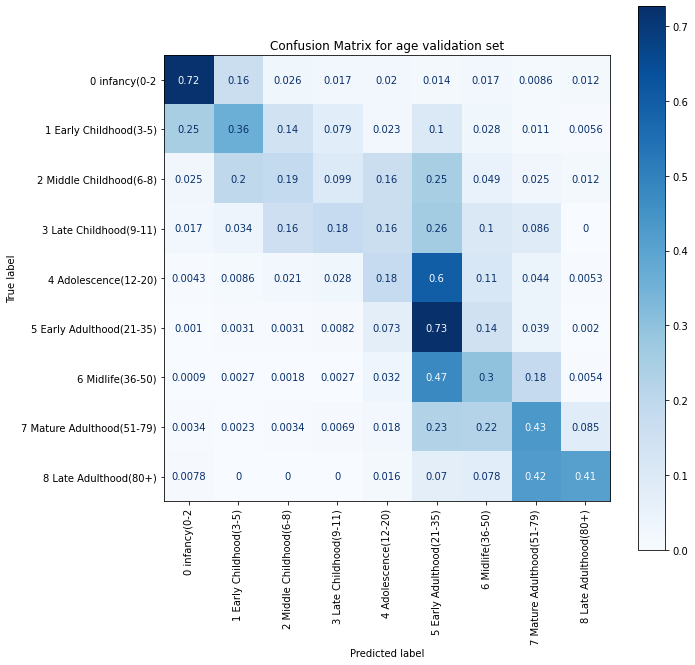

In [72]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

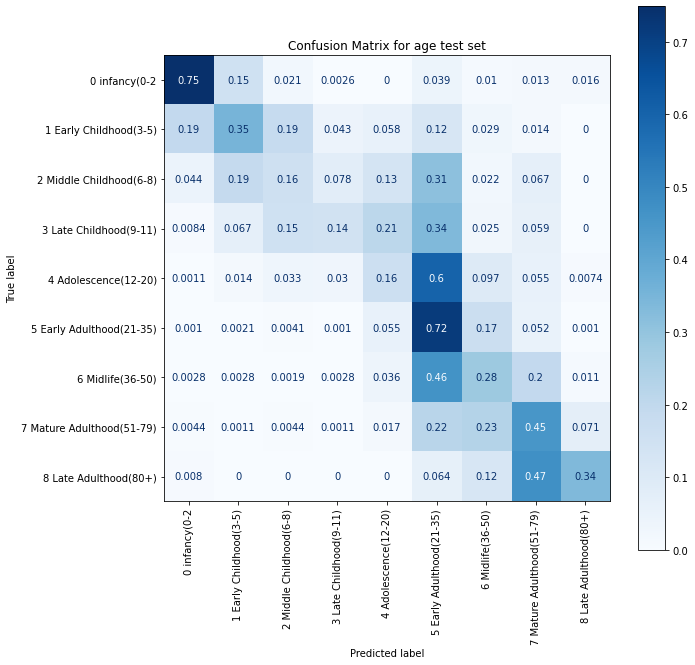

In [73]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

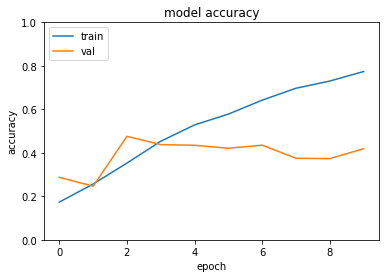

In [74]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

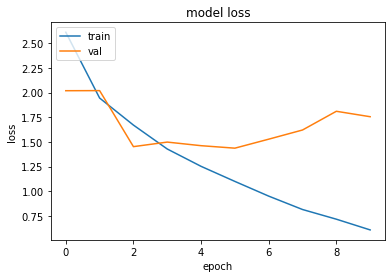

In [75]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prepare SIFT dataset

In [13]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True).astype(np.uint8)

descriptors = get_descriptors(train_img_container,100)

vocab = get_vocab(descriptors[:500],200)

histarraytrain = descriptor_to_vocab(train_img_container,vocab)

histarrayval = descriptor_to_vocab(get_images(X_val,rgb = True).astype(np.uint8),vocab)

histarraytest = descriptor_to_vocab(get_images(X_test,rgb = True).astype(np.uint8),vocab)

histarraytrain = normalize_histograms(histarraytrain)

histarrayval = normalize_histograms(histarrayval)

histarraytest = normalize_histograms(histarraytest)

In [33]:
histarraytrain = np.nan_to_num(histarraytrain)
histarrayval = np.nan_to_num(histarrayval)
histarraytest = np.nan_to_num(histarraytest)

In [55]:
histarraytrain = np.expand_dims(histarraytrain, axis=2)
histarrayval = np.expand_dims(histarrayval, axis=2)
histarrayest = np.expand_dims(histarraytest, axis=2)

### Train 1D SIFT model

In [53]:
Modelsimple=Simplemodel1D(np.expand_dims(histarraytrain, axis=2)[0].shape,'age')

In [54]:
History = Modelsimple.fit(np.expand_dims(histarraytrain, axis=2)
                          ,y_train_label
                          ,validation_data=(np.expand_dims(histarrayval, axis=2),y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 3s 13ms/step - loss: 2.1781 - accuracy: 0.1377 - val_loss: 2.2484 - val_accuracy: 0.1196
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 2.0614 - accuracy: 0.2162 - val_loss: 2.2235 - val_accuracy: 0.1363
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 1.9779 - accuracy: 0.2573 - val_loss: 2.0044 - val_accuracy: 0.2421
Epoch 4/10
157/157 [==============================] - 2s 14ms/step - loss: 1.9061 - accuracy: 0.2909 - val_loss: 2.1031 - val_accuracy: 0.1495
Epoch 5/10
157/157 [==============================] - 2s 14ms/step - loss: 1.8005 - accuracy: 0.3351 - val_loss: 2.0784 - val_accuracy: 0.2168
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 1.6660 - accuracy: 0.4024 - val_loss: 1.8623 - val_accuracy: 0.3164
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 1.4863 - accuracy: 0.4667 - val_loss: 2.1951 - val_accuracy: 0.2118

### Get predictions

In [58]:
ypredtrain = Modelsimple.predict(histarraytrain)
ypredtest = Modelsimple.predict(histarrayest)
ypredval = Modelsimple.predict(histarrayval)

149/149 [==============================] - 0s 3ms/step


### Train classification report

In [59]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       585
           1       0.79      0.86      0.82       510
           2       0.83      0.83      0.83       559
           3       0.87      0.92      0.90       525
           4       0.61      0.80      0.69       426
           5       0.84      0.53      0.65       885
           6       0.59      0.72      0.65       457
           7       0.61      0.71      0.65       471
           8       0.87      0.84      0.85       577

    accuracy                           0.77      4995
   macro avg       0.77      0.78      0.77      4995
weighted avg       0.78      0.77      0.77      4995



### Validation classification report

In [60]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.35      0.50      0.41       308
           1       0.07      0.14      0.09       157
           2       0.05      0.16      0.07        95
           3       0.07      0.12      0.09        92
           4       0.10      0.11      0.10       336
           5       0.53      0.40      0.45      2073
           6       0.18      0.14      0.16       806
           7       0.25      0.20      0.22       729
           8       0.12      0.30      0.17       145

    accuracy                           0.29      4741
   macro avg       0.19      0.23      0.20      4741
weighted avg       0.34      0.29      0.30      4741



### Test classification report

In [61]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.35      0.43      0.39       328
           1       0.04      0.07      0.05       150
           2       0.03      0.10      0.05       107
           3       0.06      0.16      0.08        64
           4       0.11      0.14      0.12       304
           5       0.52      0.41      0.46      2064
           6       0.18      0.14      0.16       793
           7       0.23      0.16      0.18       799
           8       0.12      0.31      0.17       132

    accuracy                           0.28      4741
   macro avg       0.18      0.21      0.19      4741
weighted avg       0.33      0.28      0.30      4741



### Set labels and title based on label type

In [62]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

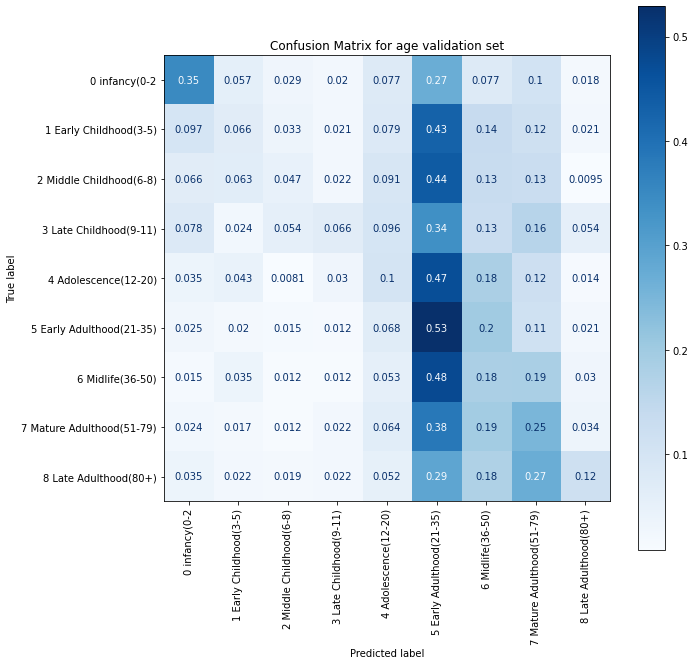

In [63]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

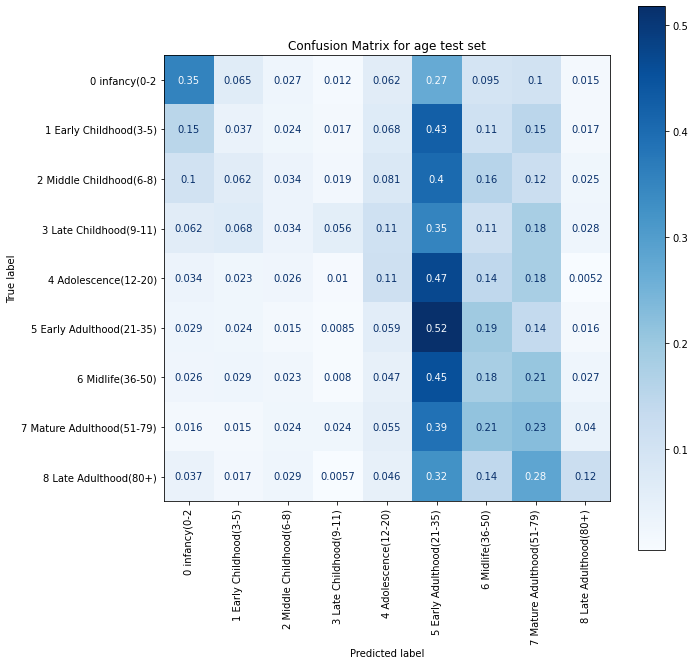

In [64]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

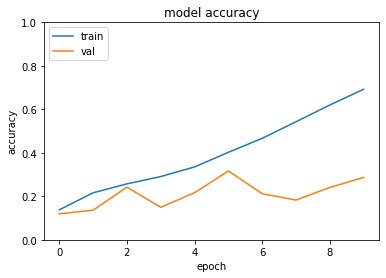

In [65]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

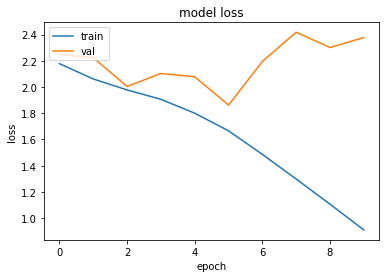

In [66]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prepare PCA dataset

In [7]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)
y_train_label = dfbalancedsubset.loc[:,'label']
y_test = y_test
y_val = y_val

In [8]:
train_img_container = train_img_container.reshape(len(train_img_container),200*200*3)
validation_img_container = validation_img_container.reshape(len(validation_img_container),200*200*3)
test_img_container = test_img_container.reshape(len(test_img_container),200*200*3)

### Get PCA with total variance ratio of 90%

In [9]:
pcax = PCA(0.9)
pcax.fit(train_img_container)
train_img_container = pcax.transform(train_img_container)
validation_img_container = pcax.transform(validation_img_container)
test_img_container = pcax.transform(test_img_container)

In [10]:
train_img_container = np.expand_dims(train_img_container, axis=2)
validation_img_container = np.expand_dims(validation_img_container, axis=2)
test_img_container = np.expand_dims(test_img_container, axis=2)

### Develop PCA model

In [15]:
Modelsimple=Simplemodel1D(train_img_container[0].shape,'age')

In [18]:
History = Modelsimple.fit(train_img_container
                          ,y_train_label
                          ,validation_data=(np.expand_dims(validation_img_container, axis=2),y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 2s 6ms/step - loss: 8.7512 - accuracy: 0.1423 - val_loss: 2.2229 - val_accuracy: 0.0384
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 2.1873 - accuracy: 0.1291 - val_loss: 2.2020 - val_accuracy: 0.0542
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 2.1654 - accuracy: 0.1397 - val_loss: 2.2450 - val_accuracy: 0.1428
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 2.1268 - accuracy: 0.1612 - val_loss: 2.2122 - val_accuracy: 0.1379
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 2.1223 - accuracy: 0.1626 - val_loss: 2.2064 - val_accuracy: 0.1367
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 2.0936 - accuracy: 0.1820 - val_loss: 2.2353 - val_accuracy: 0.1675
Epoch 7/10
157/157 [==============================] - 1s 6ms/step - loss: 2.0457 - accuracy: 0.2160 - val_loss: 2.1968 - val_accuracy: 0.1426
Epoch 

### Get predictions

In [19]:
ypredtrain = Modelsimple.predict(train_img_container)
ypredtest = Modelsimple.predict(test_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 0s 1ms/step


### Train classification report

In [20]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       0.54      0.55      0.54       540
           1       0.28      0.54      0.37       285
           2       0.15      0.41      0.22       200
           3       0.38      0.26      0.31       811
           4       0.46      0.22      0.30      1184
           5       0.11      0.16      0.13       380
           6       0.10      0.18      0.13       296
           7       0.34      0.21      0.26       868
           8       0.34      0.44      0.39       431

    accuracy                           0.30      4995
   macro avg       0.30      0.33      0.29      4995
weighted avg       0.35      0.30      0.31      4995



### Validation classification report

In [21]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.45      0.44      0.44       308
           1       0.08      0.08      0.08       157
           2       0.01      0.01      0.01        95
           3       0.02      0.16      0.04        92
           4       0.10      0.38      0.16       336
           5       0.42      0.10      0.16      2073
           6       0.19      0.09      0.12       806
           7       0.19      0.26      0.22       729
           8       0.06      0.14      0.09       145

    accuracy                           0.16      4741
   macro avg       0.17      0.18      0.15      4741
weighted avg       0.29      0.16      0.17      4741



### Test classification report

In [22]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.44      0.41      0.42       328
           1       0.07      0.09      0.08       150
           2       0.03      0.03      0.03       107
           3       0.01      0.14      0.02        64
           4       0.09      0.36      0.14       304
           5       0.45      0.10      0.16      2064
           6       0.21      0.10      0.13       793
           7       0.22      0.26      0.24       799
           8       0.08      0.20      0.11       132

    accuracy                           0.16      4741
   macro avg       0.18      0.19      0.15      4741
weighted avg       0.31      0.16      0.18      4741



### Set labels and title based on label type

In [23]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

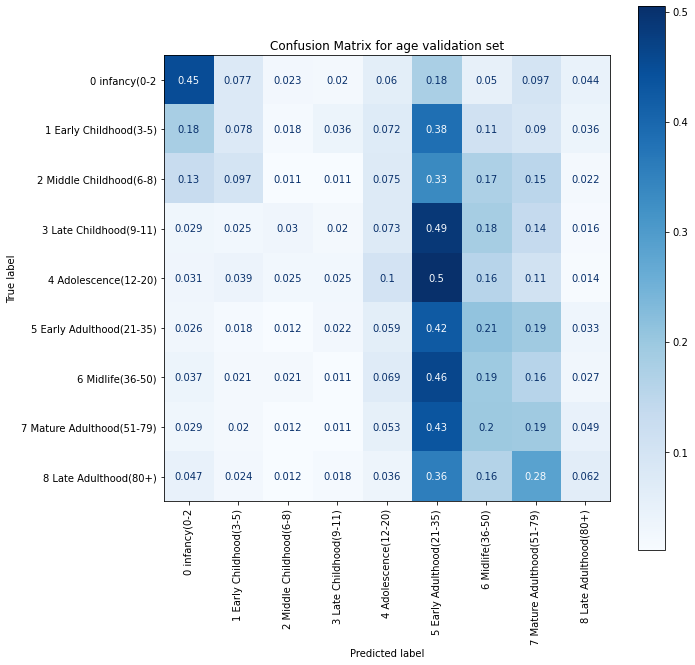

In [24]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

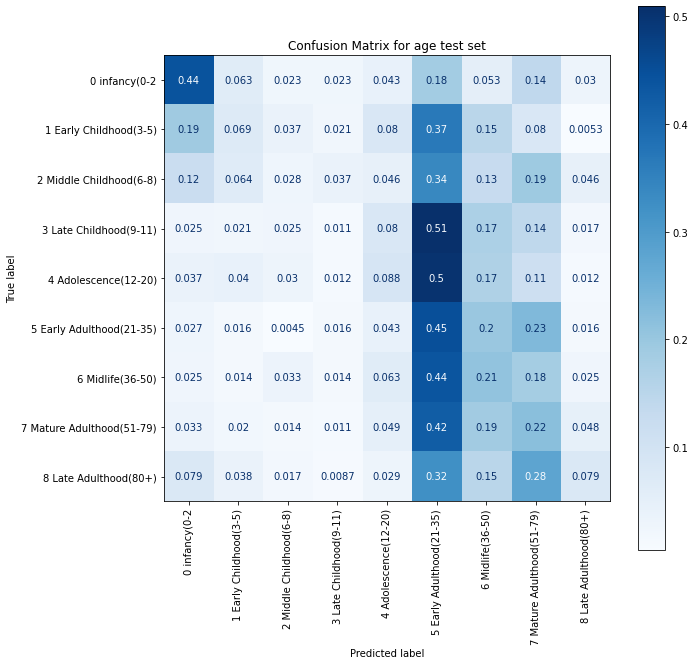

In [25]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

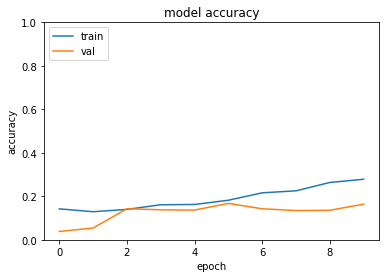

In [26]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

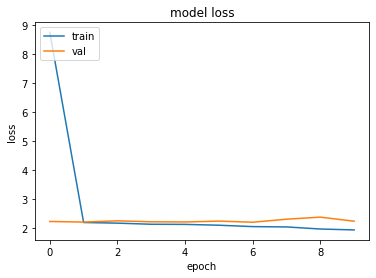

In [27]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Prepare RFS dataset

In [28]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True)
validation_img_container = get_images(X_val,rgb = True)
test_img_container = get_images(X_test,rgb = True)
y_train_label = dfbalancedsubset.loc[:,'label']
y_test = y_test
y_val = y_val

In [29]:
train_img_container = train_img_container.reshape(len(train_img_container),200*200*3)
validation_img_container = validation_img_container.reshape(len(validation_img_container),200*200*3)
test_img_container = test_img_container.reshape(len(test_img_container),200*200*3)

In [30]:
selector = SelectFromModel(RandomForestClassifier())
selector.fit(train_img_container, y_train_label)

SelectFromModel(estimator=RandomForestClassifier())

In [32]:
train_img_container = train_img_container[:,selector.get_support()]
validation_img_container = validation_img_container[:,selector.get_support()]
test_img_container = test_img_container[:,selector.get_support()]

In [33]:
train_img_container.shape

(4995, 36407)

In [112]:
train_img_container = np.expand_dims(train_img_container, axis=2)
validation_img_container = np.expand_dims(validation_img_container, axis=2)
test_img_container = np.expand_dims(test_img_container, axis=2)

### Develop RFS model

In [113]:
Modelsimple=Simplemodel1D(train_img_container[0].shape,'age')

In [114]:
History = Modelsimple.fit(train_img_container
                          ,y_train_label
                          ,validation_data=(validation_img_container,y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 257s 2s/step - loss: 13.8846 - accuracy: 0.2801 - val_loss: 2.0288 - val_accuracy: 0.2080
Epoch 2/10
157/157 [==============================] - 246s 2s/step - loss: 1.2403 - accuracy: 0.5499 - val_loss: 1.6474 - val_accuracy: 0.3550
Epoch 3/10
157/157 [==============================] - 247s 2s/step - loss: 0.8212 - accuracy: 0.7133 - val_loss: 1.7004 - val_accuracy: 0.4200
Epoch 4/10
157/157 [==============================] - 248s 2s/step - loss: 0.5130 - accuracy: 0.8196 - val_loss: 2.1764 - val_accuracy: 0.3641
Epoch 5/10
157/157 [==============================] - 248s 2s/step - loss: 0.3366 - accuracy: 0.8861 - val_loss: 2.6388 - val_accuracy: 0.3883
Epoch 6/10
157/157 [==============================] - 246s 2s/step - loss: 0.2251 - accuracy: 0.9299 - val_loss: 2.6520 - val_accuracy: 0.4128
Epoch 7/10
157/157 [==============================] - 247s 2s/step - loss: 0.1330 - accuracy: 0.9604 - val_loss: 2.7087 - val_accuracy: 0.373

### Get predictions

In [115]:
ypredtrain = Modelsimple.predict(train_img_container)
ypredtest = Modelsimple.predict(test_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 44s 296ms/step


### Train classification report

In [116]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       571
           1       0.94      0.98      0.95       532
           2       0.99      0.92      0.95       595
           3       0.93      0.98      0.95       526
           4       0.95      0.94      0.94       563
           5       0.92      0.93      0.92       550
           6       0.91      0.98      0.94       515
           7       0.99      0.81      0.89       680
           8       0.82      0.99      0.90       463

    accuracy                           0.94      4995
   macro avg       0.94      0.94      0.94      4995
weighted avg       0.94      0.94      0.94      4995



### Validation classification report

In [117]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       308
           1       0.26      0.22      0.24       157
           2       0.12      0.43      0.19        95
           3       0.16      0.21      0.18        92
           4       0.14      0.25      0.18       336
           5       0.69      0.37      0.49      2073
           6       0.29      0.30      0.30       806
           7       0.36      0.55      0.43       729
           8       0.22      0.34      0.27       145

    accuracy                           0.39      4741
   macro avg       0.34      0.38      0.34      4741
weighted avg       0.49      0.39      0.41      4741



### Test classification report

In [118]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       328
           1       0.27      0.26      0.27       150
           2       0.15      0.44      0.23       107
           3       0.13      0.23      0.17        64
           4       0.16      0.30      0.21       304
           5       0.70      0.37      0.48      2064
           6       0.31      0.31      0.31       793
           7       0.42      0.59      0.49       799
           8       0.17      0.32      0.22       132

    accuracy                           0.41      4741
   macro avg       0.34      0.40      0.35      4741
weighted avg       0.51      0.41      0.43      4741



### Set labels and title based on label type

In [119]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

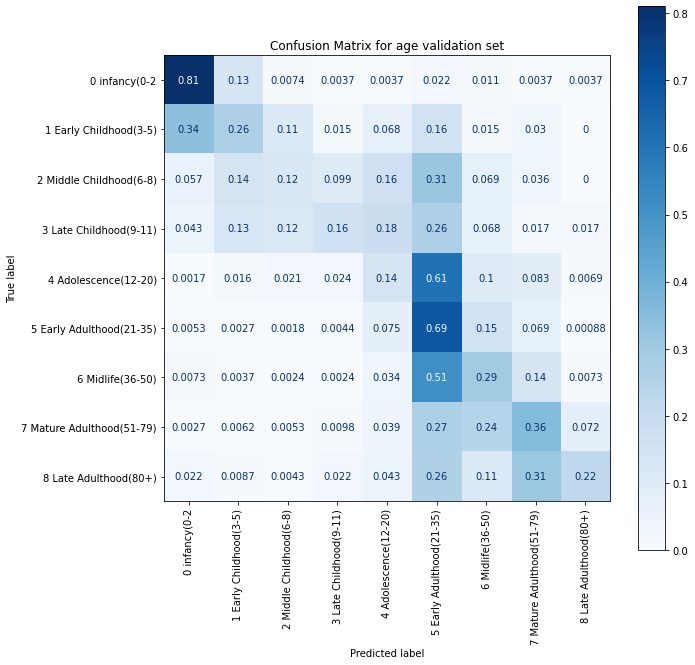

In [120]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

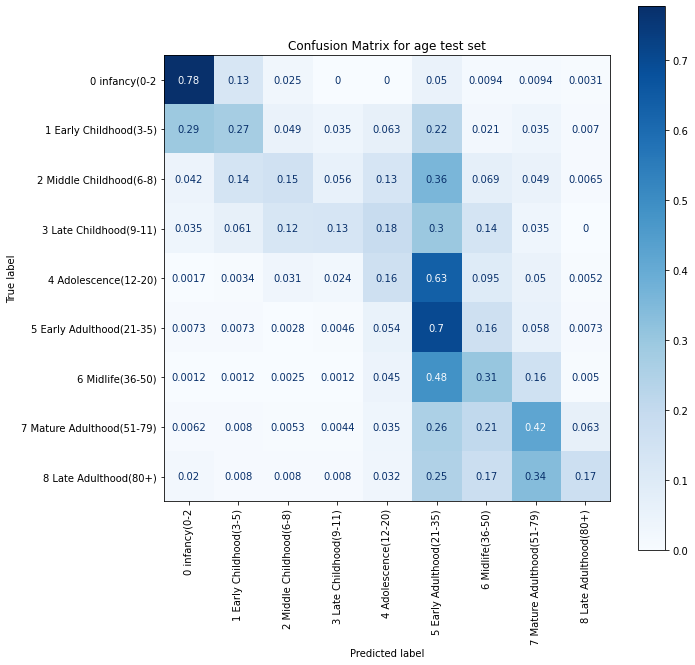

In [121]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

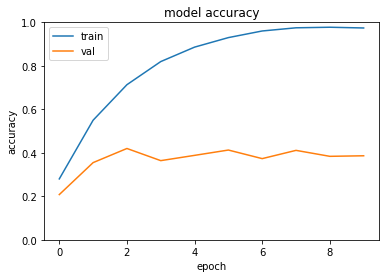

In [122]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

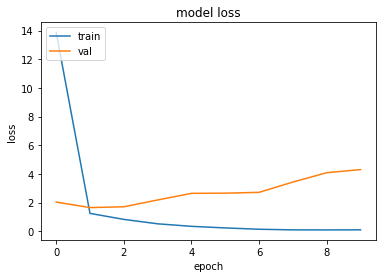

In [123]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Get Normalized data

In [8]:
train_img_container = get_images(dfbalancedsubset.loc[:,'file'],rgb = True, normalize = True)
validation_img_container = get_images(X_val,rgb = True,normalize = True)

In [22]:
del train_img_container
del validation_img_container

In [23]:
test_img_container = get_images(X_test,rgb = True,normalize = True)

In [12]:
y_train_label = dfbalancedsubset.loc[:,'label']
y_test = y_test
y_val = y_val

In [ ]:
del train_img_container
del validation_img_container
del test_img_container
del Modelsimple

In [9]:
callback = tf.keras.callbacks.EarlyStopping(
monitor="val_accuracy",
verbose=1,
patience = 10,
mode="auto",
restore_best_weights=True,
)

### Create and run normalized model

In [10]:
Modelsimple=Simplemodel(train_img_container[0].shape,'age')

In [13]:
History = Modelsimple.fit(train_img_container
                          ,y_train_label
                          ,validation_data=(validation_img_container,y_val)
                          ,epochs=10
                          ,callbacks = [callback])

Epoch 1/10
157/157 [==============================] - 137s 865ms/step - loss: 2.6680 - accuracy: 0.1948 - val_loss: 2.4083 - val_accuracy: 0.1837
Epoch 2/10
157/157 [==============================] - 126s 803ms/step - loss: 1.6974 - accuracy: 0.3580 - val_loss: 1.6331 - val_accuracy: 0.3046
Epoch 3/10
157/157 [==============================] - 126s 801ms/step - loss: 1.3997 - accuracy: 0.4655 - val_loss: 1.6245 - val_accuracy: 0.3970
Epoch 4/10
157/157 [==============================] - 127s 811ms/step - loss: 1.2072 - accuracy: 0.5487 - val_loss: 1.6724 - val_accuracy: 0.3786
Epoch 5/10
157/157 [==============================] - 126s 805ms/step - loss: 1.0691 - accuracy: 0.6008 - val_loss: 1.6612 - val_accuracy: 0.3870
Epoch 6/10
157/157 [==============================] - 125s 796ms/step - loss: 0.9202 - accuracy: 0.6625 - val_loss: 1.8375 - val_accuracy: 0.3923
Epoch 7/10
157/157 [==============================] - 126s 800ms/step - loss: 0.7592 - accuracy: 0.7207 - val_loss: 1.8349 -

### Get predictions

In [15]:
ypredtrain = Modelsimple.predict(train_img_container)
ypredval = Modelsimple.predict(validation_img_container)

149/149 [==============================] - 26s 171ms/step


In [24]:
ypredtest = Modelsimple.predict(test_img_container)

149/149 [==============================] - 25s 166ms/step


### Train classification report

In [16]:
print(classification_report(np.argmax(ypredtrain,axis=1),y_train_label))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       560
           1       0.82      0.90      0.86       506
           2       0.85      0.90      0.87       526
           3       0.90      0.91      0.91       549
           4       0.85      0.74      0.79       640
           5       0.82      0.78      0.80       578
           6       0.57      0.90      0.70       354
           7       0.67      0.75      0.71       497
           8       0.98      0.69      0.81       785

    accuracy                           0.82      4995
   macro avg       0.82      0.83      0.82      4995
weighted avg       0.84      0.82      0.82      4995



### Validation classification report

In [17]:
print(classification_report(y_val,np.argmax(ypredval,axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       308
           1       0.35      0.41      0.38       157
           2       0.12      0.26      0.17        95
           3       0.10      0.18      0.13        92
           4       0.14      0.32      0.19       336
           5       0.68      0.45      0.54      2073
           6       0.32      0.19      0.23       806
           7       0.33      0.31      0.32       729
           8       0.17      0.72      0.27       145

    accuracy                           0.39      4741
   macro avg       0.34      0.40      0.33      4741
weighted avg       0.49      0.39      0.42      4741



### Test classification report

In [25]:
print(classification_report(y_test,np.argmax(ypredtest,axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       328
           1       0.26      0.31      0.29       150
           2       0.14      0.27      0.18       107
           3       0.10      0.22      0.14        64
           4       0.13      0.34      0.19       304
           5       0.67      0.44      0.53      2064
           6       0.34      0.19      0.24       793
           7       0.39      0.33      0.36       799
           8       0.13      0.67      0.22       132

    accuracy                           0.39      4741
   macro avg       0.33      0.38      0.32      4741
weighted avg       0.49      0.39      0.42      4741



### Set labels and title based on label type

In [18]:
labels = []
title = ''
if(Labeltype == 'age'):
    labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
    title = 'Confusion Matrix for age '
if(Labeltype == 'race'):
    labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
    title = 'Confusion Matrix for race '
if(Labeltype == 'gender'):
    labels = ['0 Male','1 Female']
    title = 'Confusion Matrix for age '

### Validation confusion matrix

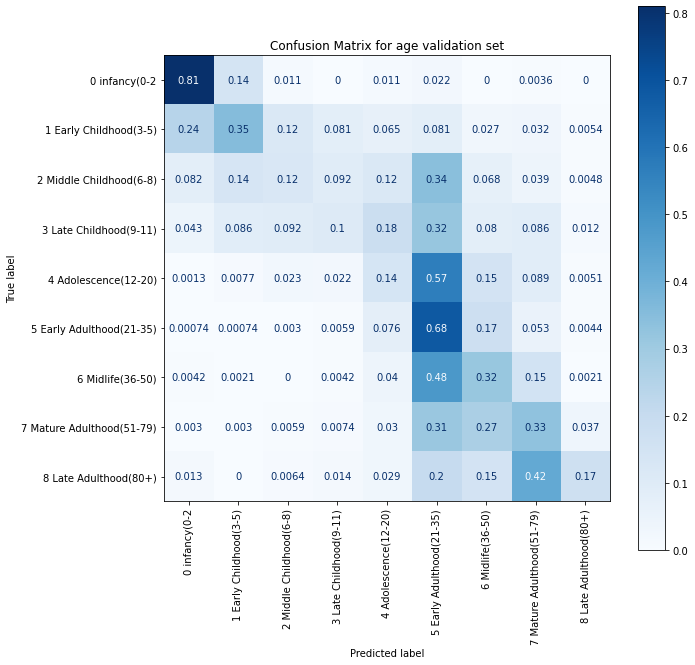

In [19]:
cm = confusion_matrix(np.argmax(ypredval,axis=1),y_val,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'validation set')
plt.xticks(rotation = 90)

plt.show()

### Test confusion matrix

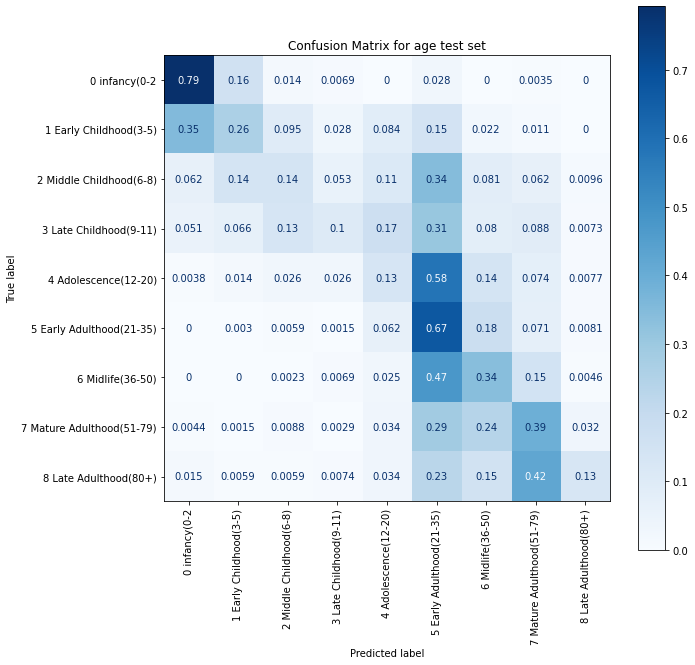

In [26]:
cm = confusion_matrix(np.argmax(ypredtest,axis=1),y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title(title + 'test set')
plt.xticks(rotation = 90)

plt.show()

### Train, Validation accuracy plot

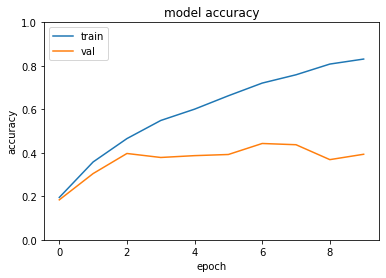

In [20]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0,top=1)
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train, Validation loss plot

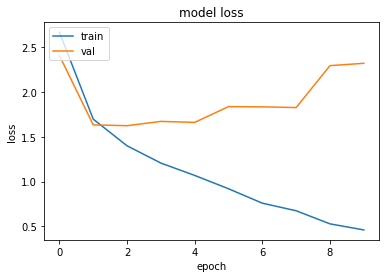

In [21]:
fig, ax = plt.subplots()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Plot Precisions for all preprocessing techniques

In [34]:
yaccuracy = [0.56,0.42,0.39,0.39,0.16,0.29]
yavgprecision = [0.30,0.39,0.34,0.34,0.17,0.19]
yavgrecall = [0.32,0.42,0.40,0.38,0.18,0.23]
yavgf1 = [0.29,0.38,0.33,0.34,0.15,0.20]
xlabels = ['unbalanced','balanced','normalized','RFS','PCA','SIFT']

C:\Users\thanh\AppData\Local\Temp\ipykernel_3028\2137317281.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+xlabels)
C:\Users\thanh\AppData\Local\Temp\ipykernel_3028\2137317281.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['accuracy', 'macro precision','macro recall','macro f1'])


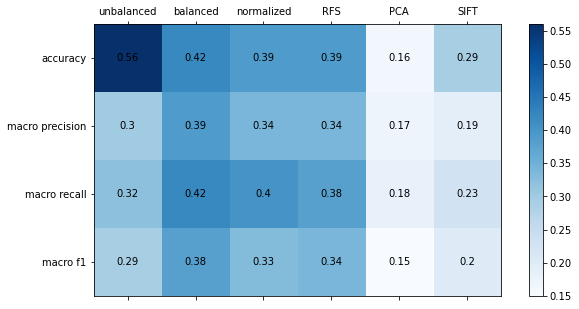

In [48]:
fig, ax = plt.subplots(figsize = (10,5))

intersection_matrix = np.array([yaccuracy,yavgprecision,yavgrecall,yavgf1])

cax = ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
ax.set_xticklabels(['']+xlabels)
ax.set_yticklabels([''] + ['accuracy', 'macro precision','macro recall','macro f1'])
fig.colorbar(cax)
for i in range(6):
    for j in range(4):
        c = intersection_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')